In [1]:
import matplotlib.pyplot as plt
import numpy as np

import time

import sys
import os

from datetime import datetime
import subprocess

from os.path import exists

import read_config_utils as cu

import matplotlib as mpl

In [2]:

#fitType = 'bin center approximation'
fitType = 'integral within bin'





rcond_val = 0.001

diagonal_constant = 1.0



In [3]:
input_dir = 'hist-pdf-study-1d-read-input-v1a-smearing-0.75'

ndim = 1


In [4]:
sample_input_dir = cu.get_par( '%s/config.txt' % input_dir, 'input_dir')
print('  sample_input_dir = %s' % sample_input_dir )

true_mu = np.zeros( shape=(ndim))
true_cov = np.zeros( shape=(ndim,ndim) )
true_sig = np.zeros( shape=(ndim))

pv = cu.get_par( '%s/config.txt' % sample_input_dir,'mu_true')
true_mu[0] = float(pv)

pv = cu.get_par( '%s/config.txt' % sample_input_dir,'var_true')
true_cov[0,0] = float(pv)
true_sig[0] = np.sqrt(float(pv))


  sample_input_dir = input-samples-smearing-0.75-v1a


In [5]:
n_samples = 0

for fi in range(5000) :
    
    fname = '%s/sample-%04d.npy' % (sample_input_dir, fi)
    
    if exists(fname) :
        n_samples = n_samples + 1
        
print("\n\n Found %d samples.\n\n" % n_samples )



 Found 500 samples.




In [6]:
def read_sample( input_dir, sample_index ) :
    
    with open( '%s/sample-%04d.npy' % (input_dir, sample_index), 'rb' ) as f :
        read_true_pts = np.load(f)
        read_true_det_pts = np.load(f)
        read_train_pts = np.load(f)
        read_train_det_pts = np.load(f)

    ngen_true = len(read_true_pts)
    ngen_train = len(read_train_pts)

    this_ngen_true = ngen_true

    #-- package these in the same format as what I was using.

    true_pts = np.zeros( shape=(ngen_true,1) )
    true_pts[:,0] = read_true_pts

    true_det_pts = np.zeros( shape=(ngen_true,1) )
    true_det_pts[:,0] = read_true_det_pts

    train_pts = np.zeros( shape=(ngen_train,1) )
    train_pts[:,0] = read_train_pts

    train_det_pts = np.zeros( shape=(ngen_train,1) )
    train_det_pts[:,0] = read_train_det_pts
    
    return_dict = {}
    
    return_dict['true_pts'] = true_pts
    return_dict['true_det_pts'] = true_det_pts
    return_dict['train_pts'] = train_pts
    return_dict['train_det_pts'] = train_det_pts
    return_dict['ngen_true'] = ngen_true
    return_dict['ngen_train'] = ngen_train
    
    return return_dict
    
    

## Calculate the model parameters from simple average and covariance from weighted events

In [7]:
def calc_mean_cov( weights, fi1, fi2 ) :

    return_dict = {}
    
    wsum = np.sum( weights )
    
    wx1 = np.sum( weights * train_pts[:,fi1] )
    wx2 = np.sum( weights * train_pts[:,fi2] )
    wx1x2 = np.sum( weights * train_pts[:,fi1] * train_pts[:,fi2] )

    x1 = wx1 / wsum
    x2 = wx2 / wsum

    x1x2 = wx1x2 / wsum
    
    cov12 = x1x2 - x1*x2

    
    return_dict["mean_x1"] = x1
    return_dict["mean_x2"] = x2
    return_dict["cov_x1x2"] = cov12    
    
    if fi1 != fi2 :
        wx1x1 = np.sum( weights * train_pts[:,fi1] * train_pts[:,fi1] )
        wx2x2 = np.sum( weights * train_pts[:,fi2] * train_pts[:,fi2] )
        cov11 = wx1x1 / wsum - x1*x1
        cov22 = wx2x2 / wsum - x2*x2

        rms1 = np.sqrt(cov11)
        rms2 = np.sqrt(cov22)
        rho12 = cov12 / (rms1*rms2)     
    
        return_dict["rho12"] = rho12
        return_dict["rms1"] = rms1
        return_dict["rms2"] = rms2
    else :
        rms1 = np.sqrt(cov12)
        return_dict["rms1"] = rms1
        
    return return_dict


    

In [8]:
%%time

all_mean = np.zeros( shape=(ndim,n_samples) )
all_rms = np.zeros( shape=(ndim,n_samples) )
all_cov = np.zeros( shape=(ndim,ndim,n_samples) )
all_rho = np.zeros( shape=(ndim,ndim,n_samples) )

all_weight_min = np.zeros( n_samples )
all_weight_max = np.zeros( n_samples )

all_weight_sum = np.zeros( n_samples )


si = 0

for fi in range(n_samples) :
    
    rd = read_sample( sample_input_dir, fi )

    ngen_true = rd['ngen_true']
    ngen_train = rd['ngen_train']

    true_pts = rd['true_pts']
    true_det_pts = rd['true_det_pts']
    train_pts = rd['train_pts']
    train_det_pts = rd['train_det_pts']
    
    fname = '%s/bootstrap-weights-%03d.npy' % (input_dir, fi)
    
    if exists(fname) :
        
        print('\n----- %s exists' % fname )
        
        with open(fname,'rb') as f :
            
            final_push_weights_scaled = np.load(f)
            
        print( len(final_push_weights_scaled))
        print( final_push_weights_scaled )
        print( true_pts[:,0])

        all_weight_min[si] = np.min( final_push_weights_scaled )
        all_weight_max[si] = np.max( final_push_weights_scaled )

        all_weight_sum[si] = np.sum( final_push_weights_scaled )

        for fi1 in range(ndim) :
            for fi2 in range(fi1,ndim) :
                mean_cov = calc_mean_cov( final_push_weights_scaled, fi1, fi2 )
                all_cov[fi1,fi2,si] = mean_cov["cov_x1x2"]
                all_cov[fi2,fi1,si] = mean_cov["cov_x1x2"]
                if ( fi1 == fi2 ) :
                    print( "  %d %d  :  mean = %8.4f, RMS = %8.4f, cov = %8.4f" % 
                          (fi1, fi2, mean_cov["mean_x1"], mean_cov["rms1"], mean_cov["cov_x1x2"]))
                    all_mean[fi1,si] = mean_cov["mean_x1"]
                    all_rms[fi1,si] = mean_cov["rms1"]
                else :
                    print( "  %d %d  :  rho = %8.4f,  cov = %8.4f" %
                          (fi1, fi2, mean_cov["rho12"], mean_cov["cov_x1x2"]) )
                    all_rho[fi1,fi2,si] = mean_cov["rho12"]
                    all_rho[fi2,fi1,si] = mean_cov["rho12"]
                        
        si = si + 1
        
            


----- hist-pdf-study-1d-read-input-v1a-smearing-0.75/bootstrap-weights-000.npy exists
100000
[0.08983105 0.1191959  0.11106985 ... 0.05275142 0.04609631 0.10426372]
[-1.32904237  0.52884379  1.88137713 ... -1.70365432 -0.4812822
 -0.71103841]
  0 0  :  mean =   0.2054, RMS =   0.9113, cov =   0.8305

----- hist-pdf-study-1d-read-input-v1a-smearing-0.75/bootstrap-weights-001.npy exists
100000
[0.06230253 0.09995056 0.11375702 ... 0.08603245 0.11568659 0.11193758]
[ 0.43861579 -0.75206855 -0.6360467  ...  1.14826873  0.849246
  0.63228295]
  0 0  :  mean =   0.1914, RMS =   0.9151, cov =   0.8374

----- hist-pdf-study-1d-read-input-v1a-smearing-0.75/bootstrap-weights-002.npy exists
100000
[0.08907448 0.09911158 0.07632654 ... 0.12516028 0.12735561 0.12461107]
[ 0.61956079  0.19429187  0.33511183 ...  0.03973527 -0.67779768
 -0.04159574]
  0 0  :  mean =   0.2142, RMS =   0.9117, cov =   0.8312

----- hist-pdf-study-1d-read-input-v1a-smearing-0.75/bootstrap-weights-003.npy exists
100000


100000
[0.11170021 0.09789504 0.08357205 ... 0.06160928 0.11038322 0.12034714]
[-0.15581531  1.77827304  0.77472132 ... -0.69281611  1.03329588
  1.29199224]
  0 0  :  mean =   0.1953, RMS =   0.8858, cov =   0.7847

----- hist-pdf-study-1d-read-input-v1a-smearing-0.75/bootstrap-weights-095.npy exists
100000
[0.11442223 0.10084649 0.12394362 ... 0.09017355 0.11254174 0.07897457]
[ 0.70459145 -1.14625049 -0.08292184 ... -0.0536795  -0.88576606
 -0.43181984]
  0 0  :  mean =   0.1925, RMS =   0.9185, cov =   0.8436

----- hist-pdf-study-1d-read-input-v1a-smearing-0.75/bootstrap-weights-096.npy exists
100000
[0.12218438 0.08276963 0.10888322 ... 0.07821166 0.12186949 0.11146222]
[-0.46725401  1.11185454  1.00292456 ... -1.10488877  0.87804936
  2.08378104]
  0 0  :  mean =   0.1954, RMS =   0.9145, cov =   0.8363

----- hist-pdf-study-1d-read-input-v1a-smearing-0.75/bootstrap-weights-097.npy exists
100000
[0.11502304 0.11502304 0.11606818 ... 0.09937613 0.11701097 0.09763089]
[ 0.48799951

  0 0  :  mean =   0.2055, RMS =   0.9034, cov =   0.8162

----- hist-pdf-study-1d-read-input-v1a-smearing-0.75/bootstrap-weights-204.npy exists
100000
[0.11277555 0.09594671 0.10391925 ... 0.05569254 0.06791795 0.12234016]
[ 0.7877556   0.72197372 -1.40357432 ... -0.04306033 -0.07764255
 -0.29609526]
  0 0  :  mean =   0.1966, RMS =   0.9268, cov =   0.8590

----- hist-pdf-study-1d-read-input-v1a-smearing-0.75/bootstrap-weights-205.npy exists
100000
[0.07349562 0.12464597 0.09780304 ... 0.10845879 0.12162263 0.06449067]
[-0.38148471 -2.01129446 -0.27153413 ... -0.64763307  0.22675078
 -0.40496676]
  0 0  :  mean =   0.2135, RMS =   0.8960, cov =   0.8027

----- hist-pdf-study-1d-read-input-v1a-smearing-0.75/bootstrap-weights-206.npy exists
100000
[0.11911926 0.1246427  0.06044517 ... 0.12383025 0.01622017 0.0612007 ]
[-0.11163425  0.70371611  1.27394343 ...  0.9416448  -1.40277031
  0.46106569]
  0 0  :  mean =   0.2238, RMS =   0.9145, cov =   0.8363

----- hist-pdf-study-1d-read-inp

  0 0  :  mean =   0.2047, RMS =   0.9173, cov =   0.8414

----- hist-pdf-study-1d-read-input-v1a-smearing-0.75/bootstrap-weights-333.npy exists
100000
[0.0819766  0.06930377 0.10972399 ... 0.10464623 0.11026976 0.1173377 ]
[-0.23464013  0.06868222 -0.64050828 ... -1.12774215  0.96260421
  0.2248376 ]
  0 0  :  mean =   0.1882, RMS =   0.9236, cov =   0.8530

----- hist-pdf-study-1d-read-input-v1a-smearing-0.75/bootstrap-weights-334.npy exists
100000
[0.11633152 0.10685672 0.06153955 ... 0.08367613 0.1223113  0.11895117]
[-0.2780181  -1.52313527  1.0520264  ...  0.18252558  1.26298032
  0.42670059]
  0 0  :  mean =   0.2032, RMS =   0.9169, cov =   0.8407

----- hist-pdf-study-1d-read-input-v1a-smearing-0.75/bootstrap-weights-335.npy exists
100000
[0.11752699 0.10795211 0.07082595 ... 0.08678022 0.09338479 0.12044645]
[ 0.45253704  0.49064144  0.87197894 ... -0.03856963  1.96119346
  0.87471572]
  0 0  :  mean =   0.2109, RMS =   0.9150, cov =   0.8372

----- hist-pdf-study-1d-read-inp

  0 0  :  mean =   0.1941, RMS =   0.8987, cov =   0.8076

----- hist-pdf-study-1d-read-input-v1a-smearing-0.75/bootstrap-weights-464.npy exists
100000
[0.09957395 0.11619903 0.08299306 ... 0.11187101 0.12398538 0.06096067]
[ 0.44959048 -1.86325555  0.89480808 ...  0.74066497 -0.93735374
  0.99731072]
  0 0  :  mean =   0.1942, RMS =   0.8901, cov =   0.7923

----- hist-pdf-study-1d-read-input-v1a-smearing-0.75/bootstrap-weights-465.npy exists
100000
[0.085864   0.11142208 0.11948945 ... 0.06685803 0.09060618 0.08798272]
[ 1.48220835e+00 -5.70851082e-01  5.28667979e-01 ...  1.07629062e+00
 -6.26119551e-01  1.32198518e-03]
  0 0  :  mean =   0.2112, RMS =   0.9222, cov =   0.8504

----- hist-pdf-study-1d-read-input-v1a-smearing-0.75/bootstrap-weights-466.npy exists
100000
[0.1155501  0.12316875 0.11797785 ... 0.06572868 0.12269702 0.09499325]
[-1.46094559  0.54517699 -1.16626751 ...  0.68772606 -1.5857937
  0.43230959]
  0 0  :  mean =   0.2042, RMS =   0.9216, cov =   0.8494

----- his

<function matplotlib.pyplot.show(close=None, block=None)>

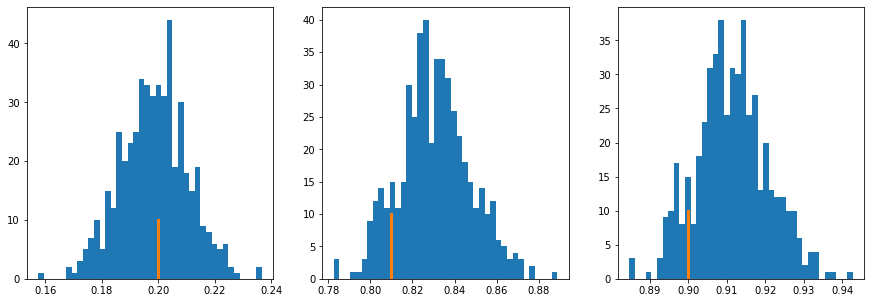

In [9]:
fig,ax = plt.subplots( ndim, 3, figsize=(3*5,ndim*5))

ymax = 10

for i in range(ndim) :
    
    if ndim > 1 :
        thisax = ax[i][0]
    else :
        thisax = ax[0]
    thisax.hist( all_mean[i], bins=40)
    thisax.plot( (true_mu[i], true_mu[i]), (0,ymax), linewidth=3 )
    
    if ndim > 1 :
        thisax = ax[i][1]
    else :
        thisax = ax[1]    
    thisax.hist( all_cov[i][i], bins=40)
    thisax.plot( (true_cov[i][i], true_cov[i][i]), (0,ymax), linewidth=3 )


    
    if ndim > 1 :
        thisax = ax[i][2]
    else :
        thisax = ax[2]    
    thisax.hist( all_rms[i], bins=40)
    thisax.plot( (true_sig[i], true_sig[i]), (0,ymax), linewidth=3 )    
    
    
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

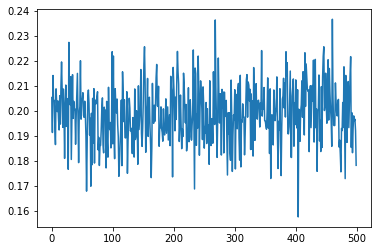

In [10]:
plt.plot(all_mean[0])
plt.show

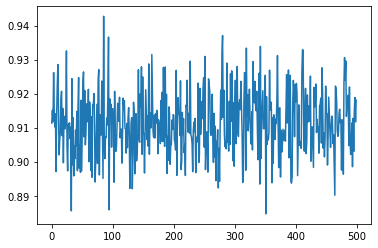

In [11]:
plt.plot(all_rms[0])

<function matplotlib.pyplot.show(close=None, block=None)>

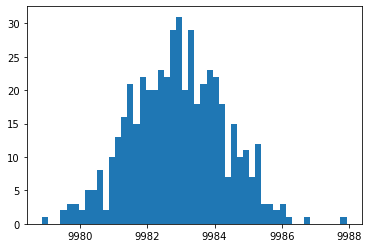

In [12]:
plt.hist( all_weight_sum, bins=50 )
plt.show

In [13]:
print( 'Weight sum RMS: %.1f' % np.sqrt( np.cov(all_weight_sum)))

Weight sum RMS: 1.4


In [14]:
print('\n')

ave_mean = np.zeros( ndim )
rms_mean = np.zeros( ndim )
rms_mean_err = np.zeros( ndim )

ave_cov = np.zeros( shape=(ndim,ndim) )
rms_cov = np.zeros( shape=(ndim,ndim) )
rms_cov_err = np.zeros( shape=(ndim,ndim) )


for fi in range(ndim) :
    
    ave_mean[fi] = np.mean( all_mean[fi] )
    ave_mean2 = np.mean( all_mean[fi]*all_mean[fi])
    rms_mean[fi] = np.sqrt( ave_mean2 - ave_mean[fi]*ave_mean[fi] )
    rms_mean_err[fi] = rms_mean[fi] / np.sqrt(2*n_samples)
    print("  feature %d  :  mean   ave %8.4f  (true %8.4f), rms %8.5f +/- %6.5f" % 
          (fi, ave_mean[fi], true_mu[fi], rms_mean[fi], rms_mean_err[fi] ))
    
print('\n')

for fi in range(ndim) :
    
    ave_rms = np.mean( all_rms[fi] )
    ave_rms2 = np.mean( all_rms[fi]*all_rms[fi])
    rms_rms = np.sqrt( ave_rms2 - ave_rms*ave_rms )
    print("  feature %d  :  RMS    ave %8.4f  (true %8.4f), rms %8.4f" % (fi, ave_rms, true_sig[fi], rms_rms ))
    
print('\n')

for fi1 in range(0,ndim-1) :
    for fi2 in range(fi1+1, ndim) :
        k = ndim - fi2 - 1
        ave_rho = np.mean( all_rho[fi1,fi2])
        ave_rho2 = np.mean( all_rho[fi1,fi2]*all_rho[fi1,fi2] )
        rms_rho = np.sqrt( ave_rho2 - ave_rho*ave_rho )
        print("  feature %d, %d  :  rho    ave %8.4f  (true %8.4f), rms %8.4f" % ( fi1, fi2, ave_rho, true_rho[fi1][k], rms_rho ))
        
print("\n")

for fi1 in range(0,ndim) :
    for fi2 in range(fi1,ndim) :
        ave_cov[fi1,fi2] = np.mean( all_cov[fi1][fi2] )
        ave_cov2 = np.mean( all_cov[fi1][fi2]*all_cov[fi1][fi2] )
        rms_cov[fi1,fi2] = np.sqrt( ave_cov2 - ave_cov[fi1,fi2]*ave_cov[fi1,fi2] )
        rms_cov_err[fi1,fi2] = rms_cov[fi1,fi2]/np.sqrt(2*n_samples)
        print("  feature %d, %d  :  cov    ave %8.4f  (true %8.4f), rms %8.5f +/- %6.5f" %
              (fi1, fi2, ave_cov[fi1,fi2], true_cov[fi1,fi2], rms_cov[fi1,fi2], rms_cov_err[fi1,fi2] ) )

print("\n")



  feature 0  :  mean   ave   0.1987  (true   0.2000), rms  0.01178 +/- 0.00037


  feature 0  :  RMS    ave   0.9114  (true   0.9000), rms   0.0093




  feature 0, 0  :  cov    ave   0.8307  (true   0.8100), rms  0.01693 +/- 0.00054




In [15]:
with open( '%s/simple-calc-results.npy' % input_dir, 'wb' ) as f :
    np.save( f, ave_mean )
    np.save( f, rms_mean )
    np.save( f, ave_cov )
    np.save( f, rms_cov )

In [16]:
with open( '%s/simple-calc-per-sample-results.npy' % input_dir, 'wb' ) as f :
    np.save( f, all_mean )
    np.save( f, all_cov )


## Run the unbinned ML fits

In [17]:
import ROOT
import gc

Module libc not found.


Welcome to JupyROOT 6.30/09


In [18]:
ROOT.gSystem.Load('./RooMultiVarGaussian2e_cxx.so')

0

In [19]:
width_factor_mean = 10
width_factor_cov = 10

In [20]:
covdict = {}


for i in range(ndim) :
    for j in range(ndim) :
        if ( j < i ) : continue
        vname = "cov%d%d" % (i,j)
        startval = ave_cov[i][j]
        minval = ave_cov[i][j] - width_factor_cov * rms_cov[i][j]
        maxval = ave_cov[i][j] + width_factor_cov * rms_cov[i][j]   
        print(' parameter %s  min %8.4f, max %8.4f' % (vname, minval, maxval))
        if ( i == j ) :
            covdict[vname] =  ROOT.RooRealVar( "cov%d%d" % (i,j), "cov%d%d" % (i,j), startval, minval, maxval )
        else :
            covdict[vname] =  ROOT.RooRealVar( "cov%d%d" % (i,j), "cov%d%d" % (i,j), startval, minval, maxval )
        covdict[vname].Print()
        

 parameter cov00  min   0.6614, max   1.0000
RooRealVar::cov00 = 0.830672  L(0.661389 - 0.999956) 


In [21]:
covRAL = ROOT.RooArgList()


for i in range(ndim) :
    for j in range(ndim) :
        if ( j < i ) : continue
        vname = "cov%d%d" % (i,j)
        covRAL.add( covdict[vname] )


In [22]:
ralind = 0
for i in range(ndim) :
    for j in range(ndim) :
        if ( j < i ) : continue
        print( "  %d, %d :  %2d :  %s  %8.3f" % (i,j, ralind, covRAL.at(ralind).GetName(), covRAL.at(ralind).getVal() )) 
        ralind = ralind + 1

  0, 0 :   0 :  cov00     0.831


In [23]:
xDict = {}
muDict = {}

xVec = ROOT.RooArgList()
muVec = ROOT.RooArgList()


for i in range(ndim) :
    vname = "x%d" % i
    xDict[vname] = ROOT.RooRealVar( vname, vname, 0., -10., 10. )
    xVec.add( xDict[vname] )
    vname = "mu_x%d" % i
    startval = ave_mean[i]
    minval = ave_mean[i] - width_factor_mean * rms_mean[i]
    maxval = ave_mean[i] + width_factor_mean * rms_mean[i]
    print('  feature %d  mean :  min %8.4f, max %8.4f' % (i, minval, maxval))
    muDict[vname] =  ROOT.RooRealVar( vname, vname, startval, minval, maxval )
    muDict[vname].Print()
    muVec.add( muDict[vname] )
    
    
weight = ROOT.RooRealVar("weight","weight", 0., 100. )

  feature 0  mean :  min   0.0809, max   0.3166
RooRealVar::mu_x0 = 0.198744  L(0.0809118 - 0.316575) 


In [24]:
rmvg = ROOT.RooMultiVarGaussian2e("rmvg","rmvg", xVec, muVec, covRAL )

  Setting _prevCovVals[0] to 0.830672
 i,j = 0,0

1x1 matrix is as follows

     |      0    |
------------------
   0 |     0.8307 


1x1 matrix is as follows

     |      0    |
------------------
   0 |          0 



 cov inverse.

1x1 matrix is as follows

     |      0    |
------------------
   0 |      1.204 



 Check of inverse

1x1 matrix is as follows

     |      0    |
------------------
   0 |          1 



In [25]:
n_fits = 50

fit_results_mean_val = np.zeros( shape=(ndim, n_fits ) )
fit_results_mean_err = np.zeros( shape=(ndim, n_fits ) )
fit_results_cov_val = np.zeros( shape=(ndim, ndim, n_fits ) )
fit_results_cov_err = np.zeros( shape=(ndim, ndim, n_fits ) )

In [26]:
%%time



for bi in range( n_fits ) :
    
    print("\n\n --- bootstrap sample %3d" % bi, flush=True )
    sys.stdout.flush()

    rd = read_sample( sample_input_dir, bi )

    ngen_true = rd['ngen_true']
    ngen_train = rd['ngen_train']

    true_pts = rd['true_pts']
    true_det_pts = rd['true_det_pts']
    train_pts = rd['train_pts']
    train_det_pts = rd['train_det_pts']
    
    
    fname = '%s/bootstrap-weights-%03d.npy' % (input_dir, bi)    
    print('Reading weights file : %s' % fname )
    
    with open(fname,'rb') as f :
        bootstrap_sample_weights = np.load(f)
        
    data_weighted = ROOT.RooDataSet("data_weighted","data_weighted", ROOT.RooArgSet(xVec,weight), ROOT.RooFit.WeightVar("weight"))
    ROOT.SetOwnership( data_weighted, True )
    
    print('Filling RooDataSet with %d events' % len(bootstrap_sample_weights) )
    for i in range( len(bootstrap_sample_weights) ) :
        for j in range( ndim ) :
            xVec[j].setVal( train_pts[i,j] )
        weight.setVal( bootstrap_sample_weights[i] )
        data_weighted.add( ROOT.RooArgSet(xVec,weight), weight.getVal() )
        
    print("  Running fit...")
    sys.stdout.flush()
        
    rfr = rmvg.fitTo( data_weighted, ROOT.RooFit.SumW2Error(False), ROOT.RooFit.Save(True), ROOT.RooFit.NumCPU(28))
    ROOT.SetOwnership( rfr, True )
    
    for i in range(ndim) :
        fit_mean = muDict["mu_x%d" % i].getVal()
        fit_mean_err = muDict["mu_x%d" % i].getError()
        fit_results_mean_val[i,bi] = fit_mean
        fit_results_mean_err[i,bi] = fit_mean_err
        print("  %2d :  mu = %8.4f   (true %8.4f) err %8.4f  diff %8.4f   diff/err  %5.2f" % 
              (i, fit_mean, true_mu[i], fit_mean_err, (fit_mean-true_mu[i]), (fit_mean-true_mu[i])/fit_mean_err) )

    print("\n")

    for i in range(ndim) :
        for j in range(ndim) :
            if ( j < i ) : continue
            fit_cov = covdict["cov%d%d" % (i,j)].getVal()
            fit_cov_err = covdict["cov%d%d" % (i,j)].getError()
            fit_results_cov_val[i,j,bi] = fit_cov
            fit_results_cov_err[i,j,bi] = fit_cov_err
            print(" %2d, %2d :  cov  %8.4f  (true %8.4f) err %8.4f  diff %8.4f   diff/err  %5.2f" % 
                  (i,j, fit_cov, true_cov[i][j], fit_cov_err, 
                   (fit_cov-true_cov[i][j]), (fit_cov-true_cov[i][j])/fit_cov_err)  )
    
    print("Cleaning up.")
    del bootstrap_sample_weights
    del data_weighted
    del rfr
    gc.collect()
    #print("Pausing for 3 seconds.")
    #time.sleep(3)        
        
        



 --- bootstrap sample   0
Reading weights file : hist-pdf-study-1d-read-input-v1a-smearing-0.75/bootstrap-weights-000.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2054   (true   0.2000) err   0.0091  diff   0.0054   diff/err   0.59


  0,  0 :  cov    0.8306  (true   0.8100) err   0.0117  diff   0.0206   diff/err   1.75
Cleaning up.


 --- bootstrap sample   1
Reading weights file : hist-pdf-study-1d-read-input-v1a-smearing-0.75/bootstrap-weights-001.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1913   (true   0.2000) err   0.0092  diff  -0.0087   diff/err  -0.96


  0,  0 :  cov    0.8376  (true   0.8100) err   0.0118  diff   0.0276   diff/err   2.33
Cleaning up.


 --- bootstrap sample   2
Reading weights file : hist-pdf-study-1d-read-input-v1a-smearing-0.75/bootstrap-weights-002.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2142   (true   0.2000) err   0.0091  diff   0.0142   diff/err   1.56

  Running fit...
   0 :  mu =   0.2023   (true   0.2000) err   0.0091  diff   0.0023   diff/err   0.25


  0,  0 :  cov    0.8274  (true   0.8100) err   0.0117  diff   0.0174   diff/err   1.49
Cleaning up.


 --- bootstrap sample  23
Reading weights file : hist-pdf-study-1d-read-input-v1a-smearing-0.75/bootstrap-weights-023.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2103   (true   0.2000) err   0.0091  diff   0.0103   diff/err   1.13


  0,  0 :  cov    0.8354  (true   0.8100) err   0.0118  diff   0.0254   diff/err   2.15
Cleaning up.


 --- bootstrap sample  24
Reading weights file : hist-pdf-study-1d-read-input-v1a-smearing-0.75/bootstrap-weights-024.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1938   (true   0.2000) err   0.0093  diff  -0.0062   diff/err  -0.67


  0,  0 :  cov    0.8696  (true   0.8100) err   0.0123  diff   0.0596   diff/err   4.85
Cleaning up.


 --- bootstrap sample  25
Reading weights file : hist-pd

Reading weights file : hist-pdf-study-1d-read-input-v1a-smearing-0.75/bootstrap-weights-045.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1993   (true   0.2000) err   0.0090  diff  -0.0007   diff/err  -0.08


  0,  0 :  cov    0.8066  (true   0.8100) err   0.0114  diff  -0.0034   diff/err  -0.30
Cleaning up.


 --- bootstrap sample  46
Reading weights file : hist-pdf-study-1d-read-input-v1a-smearing-0.75/bootstrap-weights-046.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2017   (true   0.2000) err   0.0090  diff   0.0017   diff/err   0.18


  0,  0 :  cov    0.8189  (true   0.8100) err   0.0116  diff   0.0089   diff/err   0.77
Cleaning up.


 --- bootstrap sample  47
Reading weights file : hist-pdf-study-1d-read-input-v1a-smearing-0.75/bootstrap-weights-047.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2201   (true   0.2000) err   0.0090  diff   0.0201   diff/err   2.24


  0,  0 :  cov    0.8044 

Info in <Minuit2>: MnSeedGenerator Computing seed using NumericalGradient calculator
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =       14163.37119 Edm =  -6.522413504e-08 NCalls =      9
Info in <Minuit2>: NegativeG2LineSearch Doing a NegativeG2LineSearch since one of the G2 component is negative
Info in <Minuit2>: MnSeedGenerator Negative G2 found - new state: 
  Minimum value : 13237.42754
  Edm           : 0.2643492045
  Internal parameters:	[ -0.0006830076308 -5.887217797e-17]	
  Internal gradient  :	[  -0.001223230765      -9.39277324]	
  Internal covariance matrix:
[[   0.0096459661              0]
 [              0    0.011985339]]]
Info in <Minuit2>: MnSeedGenerator Initial state  
  Minimum value : 13237.42754
  Edm           : 0.2643492045
  Internal parameters:	[ -0.0006830076308 -5.887217797e-17]	
  Internal gradient  :	[  -0.001223230765      -9.39277324]	
  Internal covariance matrix:
[[   0.0096459661              0]
 [              0    0.011985339]]]
Info i

In [27]:
with open( '%s/fit-results.npy' % input_dir, 'wb' ) as f :
    np.save( f, fit_results_mean_val )
    np.save( f, fit_results_mean_err )
    np.save( f, fit_results_cov_val )
    np.save( f, fit_results_cov_err )

In [28]:
n_for_plot = 0

n_boot = len(all_mean[0])
n_fit  = len(fit_results_mean_val[0])

if n_boot > n_fit :
    n_for_plot = n_fit
else :
    n_for_plot = n_boot

print('  n_boot = %d,   n_fit = %d,   n_for_plot = %d' % (n_boot, n_fit, n_for_plot))



  n_boot = 500,   n_fit = 50,   n_for_plot = 50


   0 : x axis limits:  0.174, 0.230    y axis limits  0.174, 0.230


<function matplotlib.pyplot.show(close=None, block=None)>

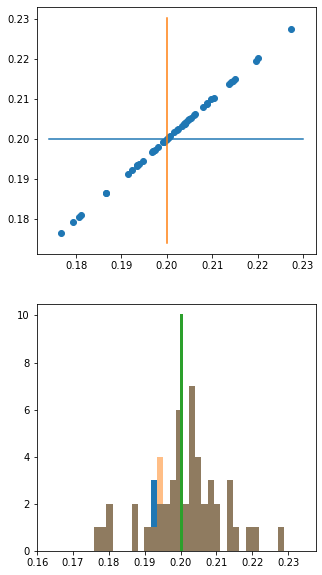

In [29]:
fig,ax = plt.subplots( 2, ndim, figsize=(5*ndim,5*2))

hbins=40
hmax = 10

for fi in range(ndim) :
    
    
    if ndim > 1 :
        thisax = ax[0][fi]
    else :
        thisax = ax[0]
        
    thisax.scatter( all_mean[fi,:n_for_plot], fit_results_mean_val[fi,:n_for_plot])
    xlow, xhigh = thisax.get_xlim()
    ylow, yhigh = thisax.get_ylim()
    print("  %2d : x axis limits:  %.3f, %.3f    y axis limits  %.3f, %.3f" % 
              (fi, xlow, xhigh, ylow, yhigh))
    thisax.plot( (xlow, xhigh), (true_mu[fi], true_mu[fi]))
    thisax.plot( (true_mu[fi], true_mu[fi]), (ylow, yhigh))
    

    if ndim > 1 :
        thisax = ax[1][fi]
    else :
        thisax = ax[1]
    
    
    thisax.hist( fit_results_mean_val[fi,:n_for_plot], bins=hbins, 
                   range=[ave_mean[fi]-3*rms_mean[fi], ave_mean[fi]+3*rms_mean[fi]])
    thisax.hist( all_mean[fi,:n_for_plot], bins=hbins, alpha=0.5,
                   range=[ave_mean[fi]-3*rms_mean[fi], ave_mean[fi]+3*rms_mean[fi]])
    thisax.plot( (true_mu[fi],true_mu[fi]),(0,hmax), linewidth=3)
    

plt.show

In [30]:
if ndim > 1 :

    fig,ax = plt.subplots( ndim, ndim, figsize=(5*ndim,5*ndim))

    for fi1 in range(ndim) :
        for fi2 in range(fi1,ndim) :
            ax[fi1][fi2].scatter( all_cov[fi1,fi2,:], fit_results_cov_val[fi1,fi2,:])
            xlow, xhigh = ax[fi1][fi2].get_xlim()
            ylow, yhigh = ax[fi1][fi2].get_ylim()
            print("  %2d, %2d : x axis limits:  %.3f, %.3f    y axis limits  %.3f, %.3f" % 
                  (fi1, fi2, xlow, xhigh, ylow, yhigh))
            ax[fi1][fi2].plot((xlow,xhigh),(true_cov[fi1][fi2], true_cov[fi1][fi2]))
            ax[fi1][fi2].plot((true_cov[fi1][fi2], true_cov[fi1][fi2]),(ylow,yhigh))

    plt.show

In [31]:
if ndim > 1 :

    fig,ax = plt.subplots( ndim, ndim, figsize=(5*ndim,5*ndim))

    hbins=40
    hmax=10

    for fi1 in range(ndim) :
        for fi2 in range(fi1,ndim) :
            ax[fi1][fi2].hist( fit_results_cov_val[fi1,fi2,:], bins=hbins, 
                             range=[ave_cov[fi1,fi2]-3*rms_cov[fi1,fi2], ave_cov[fi1,fi2]+3*rms_cov[fi1][fi2]] )
            ax[fi1][fi2].hist( all_cov[fi1,fi2,:], bins=hbins, alpha=0.5,
                             range=[ave_cov[fi1,fi2]-3*rms_cov[fi1,fi2], ave_cov[fi1,fi2]+3*rms_cov[fi1][fi2]] )
            xlow, xhigh = ax[fi1][fi2].get_xlim()
            ylow, yhigh = ax[fi1][fi2].get_ylim()
            print("  %2d, %2d : x axis limits:  %.3f, %.3f    y axis limits  %.3f, %.3f" % 
                  (fi1, fi2, xlow, xhigh, ylow, yhigh))

            ax[fi1][fi2].plot((true_cov[fi1][fi2], true_cov[fi1][fi2]),(0,hmax), linewidth=3)

    plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

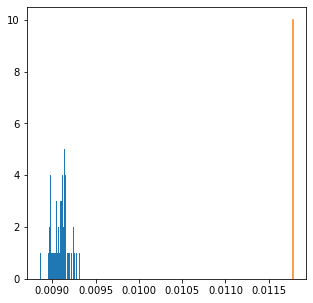

In [32]:
fig,ax = plt.subplots( 1, ndim, figsize=(5*ndim,5))

hbins = 40
hmax = 10

for fi in range(ndim) :
    if ndim > 1 :
        thisax = ax[fi]
    else :
        thisax = ax
        
    thisax.hist( fit_results_mean_err[fi,:], bins=hbins )
    thisax.plot( (rms_mean[fi], rms_mean[fi]), (0,hmax) )
    
    
plt.show

In [33]:
fit_results_mean_err

array([[0.0091125 , 0.00915077, 0.00911636, 0.00926101, 0.00914537,
        0.00910119, 0.00913823, 0.00896981, 0.00913806, 0.00922338,
        0.00928435, 0.00915368, 0.00901839, 0.00906367, 0.00908765,
        0.0091853 , 0.00920602, 0.00907561, 0.00915642, 0.00899734,
        0.0091332 , 0.00911525, 0.00909517, 0.00913913, 0.00932356,
        0.0090405 , 0.00897208, 0.00910747, 0.0090966 , 0.00911309,
        0.00906679, 0.00910138, 0.00885364, 0.00924196, 0.00899097,
        0.00912846, 0.00895752, 0.00904437, 0.00900705, 0.00909216,
        0.00904618, 0.00914709, 0.00897268, 0.0091563 , 0.00924416,
        0.00898007, 0.009048  , 0.00896853, 0.00917881, 0.00897208]])

<function matplotlib.pyplot.show(close=None, block=None)>

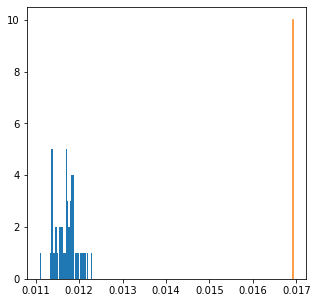

In [34]:
fig,ax = plt.subplots( 1, int((ndim*ndim+ndim)/2), figsize=(5*int((ndim*ndim+ndim)/2),5))

hbins = 40
hmax = 10

ai = 0

for fi1 in range(ndim) :
    for fi2 in range(fi1,ndim) :
        
        if ndim > 1 :
            thisax = ax[ai]
        else :
            thisax = ax

        thisax.hist( fit_results_cov_err[fi1,fi2,:], bins=hbins )
        thisax.plot( (rms_cov[fi1,fi2], rms_cov[fi1,fi2]), (0,hmax) )
        ai = ai + 1
    
plt.show

In [35]:
toy_fits_mu_rms = np.sqrt(np.var(fit_results_mean_val))
toy_fits_sig2_rms = np.sqrt(np.var(fit_results_cov_val))
toy_fits_mu_err_ave = np.average( fit_results_mean_err )
toy_fits_sig2_err_ave = np.average( fit_results_cov_err )

toy_fits_mu_ave = np.average( fit_results_mean_val )
toy_fits_sig2_ave = np.average( fit_results_cov_val )

print('\n\n')

print('  toy fits mu   ave. val  %7.4f,  true %7.4f' % (toy_fits_mu_ave, true_mu[0]))
print('  toy fits sig2 ave. val  %7.4f,  true %7.4f' % (toy_fits_sig2_ave, np.square(true_sig[0])))


print('\n\n')
print('  toy fits mu   RMS:  %7.4f,  ave fit err %7.4f' % (toy_fits_mu_rms, toy_fits_mu_err_ave))
print('  toy fits sig2 RMS:  %7.4f,  ave fit err %7.4f' % (toy_fits_sig2_rms, toy_fits_sig2_err_ave))
print('\n\n')




  toy fits mu   ave. val   0.2012,  true  0.2000
  toy fits sig2 ave. val   0.8281,  true  0.8100



  toy fits mu   RMS:   0.0104,  ave fit err  0.0091
  toy fits sig2 RMS:   0.0172,  ave fit err  0.0117





## Do the binned chi2 fits

In [36]:
binning_file = '%s/binning.npy' % sample_input_dir

with open(binning_file,'rb') as f :
    fitting_hist_bins = np.load(f)
    fitting_hist_bin_widths = np.load(f)
    fitting_hist_bin_centers = np.load(f)
    fitting_hist_n_bins = np.load(f)
    
print('\n\n fitting_hist_bins read from file : %s\n\n' % str(fitting_hist_bins))
print(' fitting_hist_n_bins  %d' % fitting_hist_n_bins )




 fitting_hist_bins read from file : [-3.33891579 -2.87825636 -2.67825636 -2.47825636 -1.35166014 -0.20355102
  0.91971765  2.14839531  3.45003214]


 fitting_hist_n_bins  8


 boot   0 weights: [0.08983105 0.1191959  0.11106985 ... 0.05275142 0.04609631 0.10426372]
 boot   1 weights: [0.06230253 0.09995056 0.11375702 ... 0.08603245 0.11568659 0.11193758]
 boot   2 weights: [0.08907448 0.09911158 0.07632654 ... 0.12516028 0.12735561 0.12461107]
 boot   3 weights: [0.11940555 0.08793567 0.11688857 ... 0.09963353 0.1092651  0.10741691]
 boot   4 weights: [0.09607143 0.06723032 0.12118805 ... 0.10929071 0.06318396 0.1235977 ]
 boot   5 weights: [0.06568161 0.05462069 0.1168526  ... 0.12085    0.06837228 0.11823219]
 boot   6 weights: [0.09659051 0.10076987 0.10842718 ... 0.11377127 0.0971416  0.11338653]
 boot   7 weights: [0.11434684 0.11467079 0.05102789 ... 0.11810454 0.1223886  0.12276311]
 boot   8 weights: [0.11094185 0.0738163  0.12680943 ... 0.12319466 0.06793045 0.06589917]
 boot   9 weights: [0.091404   0.08670876 0.08594632 ... 0.09387673 0.12073575 0.112899  ]
 boot  10 weights: [0.12773498 0.11465416 0.12722238 ... 0.09442442 0.10802812 0.11796844]

 boot  94 weights: [0.11170021 0.09789504 0.08357205 ... 0.06160928 0.11038322 0.12034714]
 boot  95 weights: [0.11442223 0.10084649 0.12394362 ... 0.09017355 0.11254174 0.07897457]
 boot  96 weights: [0.12218438 0.08276963 0.10888322 ... 0.07821166 0.12186949 0.11146222]
 boot  97 weights: [0.11502304 0.11502304 0.11606818 ... 0.09937613 0.11701097 0.09763089]
 boot  98 weights: [0.12250186 0.10151884 0.11177932 ... 0.11752555 0.05843038 0.08534257]
 boot  99 weights: [0.10407183 0.09229512 0.11775295 ... 0.10638639 0.12405559 0.11642441]
 boot 100 weights: [0.08692729 0.12311492 0.1191081  ... 0.12261315 0.12393684 0.08014528]
 boot 101 weights: [0.08191263 0.11369847 0.08824324 ... 0.08018388 0.09257524 0.03841092]
 boot 102 weights: [0.11045123 0.09143577 0.12009254 ... 0.11460493 0.09653652 0.11881076]
 boot 103 weights: [0.063366   0.12197818 0.11000081 ... 0.09067548 0.11766348 0.07183292]
 boot 104 weights: [0.09148333 0.0708842  0.0872742  ... 0.04149151 0.10646568 0.07368954]

 boot 191 weights: [0.10463034 0.1167818  0.08410744 ... 0.10042142 0.10964743 0.1185374 ]
 boot 192 weights: [0.11953243 0.0989007  0.09014133 ... 0.11839278 0.11785623 0.1067209 ]
 boot 193 weights: [0.10839171 0.0880656  0.08394385 ... 0.1200525  0.10906615 0.05646557]
 boot 194 weights: [0.09239447 0.04964952 0.12208356 ... 0.09665746 0.11123329 0.11527562]
 boot 195 weights: [0.07338118 0.12485635 0.09697006 ... 0.04564533 0.07927516 0.11242158]
 boot 196 weights: [0.10325448 0.11119265 0.11830311 ... 0.04815499 0.11852044 0.11921842]
 boot 197 weights: [0.11804108 0.11135834 0.12225128 ... 0.11967374 0.04902179 0.09705964]
 boot 198 weights: [0.12220815 0.10777732 0.11770305 ... 0.09935222 0.09054787 0.06069688]
 boot 199 weights: [0.09483349 0.11380732 0.12121666 ... 0.121875   0.08885206 0.12577377]
 boot 200 weights: [0.07067566 0.12405552 0.05850834 ... 0.07216025 0.08671224 0.05250856]
 boot 201 weights: [0.10557342 0.07575133 0.1267758  ... 0.12206904 0.10116852 0.1072877 ]

 boot 283 weights: [0.08613335 0.12372977 0.1238754  ... 0.0694601  0.11444799 0.11494757]
 boot 284 weights: [0.09184426 0.10343751 0.1045663  ... 0.11476647 0.11738468 0.11805132]
 boot 285 weights: [0.11975928 0.05001357 0.05796757 ... 0.12080638 0.11240653 0.11993789]
 boot 286 weights: [0.11889253 0.12415675 0.1168805  ... 0.07981547 0.08078992 0.02228086]
 boot 287 weights: [0.11289787 0.09521615 0.12354566 ... 0.09959221 0.09471907 0.11289787]
 boot 288 weights: [0.08547893 0.11286076 0.12101224 ... 0.04179915 0.10370928 0.06270077]
 boot 289 weights: [0.09600479 0.11692685 0.12150205 ... 0.11847756 0.1224862  0.11268503]
 boot 290 weights: [0.10995049 0.11711492 0.0451652  ... 0.11695291 0.10443541 0.10779982]
 boot 291 weights: [0.09475667 0.06392759 0.1169746  ... 0.09237435 0.04708941 0.12553349]
 boot 292 weights: [0.1140833  0.11079004 0.10913533 ... 0.12391155 0.0881869  0.09002511]
 boot 293 weights: [0.10147612 0.12064543 0.04680176 ... 0.11219627 0.09216872 0.12147871]

 boot 374 weights: [0.11508681 0.11960184 0.05261935 ... 0.11367772 0.06236954 0.05229019]
 boot 375 weights: [0.12156842 0.12293016 0.09942871 ... 0.08955936 0.09306919 0.10596473]
 boot 376 weights: [0.1211424  0.0920174  0.10426074 ... 0.08907061 0.11283028 0.1232987 ]
 boot 377 weights: [0.07486405 0.12475969 0.11476305 ... 0.02826271 0.10424059 0.09165353]
 boot 378 weights: [0.09403525 0.11981357 0.05985671 ... 0.10141454 0.0922517  0.06740639]
 boot 379 weights: [0.04706671 0.12598875 0.07137403 ... 0.10822366 0.12598875 0.11102301]
 boot 380 weights: [0.12628414 0.12607166 0.11976626 ... 0.11160307 0.08040655 0.09555387]
 boot 381 weights: [0.11434354 0.11847472 0.11849313 ... 0.10575054 0.10493182 0.10755558]
 boot 382 weights: [0.10638351 0.10443332 0.12368247 ... 0.05342278 0.09085698 0.08830446]
 boot 383 weights: [0.09399815 0.11684295 0.11436183 ... 0.04893292 0.11825374 0.11825374]
 boot 384 weights: [0.03779232 0.12148713 0.06075679 ... 0.12117707 0.12734072 0.11630918]

 boot 481 weights: [0.09384264 0.10712959 0.11674382 ... 0.07205894 0.10316091 0.06055486]
 boot 482 weights: [0.12057887 0.07510091 0.09523609 ... 0.07875985 0.09625782 0.12346571]
 boot 483 weights: [0.1249488  0.12020678 0.1225817  ... 0.11835889 0.06380429 0.11357472]
 boot 484 weights: [0.12159608 0.12169389 0.09641543 ... 0.12056113 0.11674998 0.08171203]
 boot 485 weights: [0.08272253 0.0953546  0.11681785 ... 0.11530951 0.11112086 0.09822379]
 boot 486 weights: [0.09825697 0.11627327 0.11873466 ... 0.09683866 0.05597689 0.04791451]
 boot 487 weights: [0.12485473 0.09821519 0.1194846  ... 0.12128299 0.12026555 0.10985832]
 boot 488 weights: [0.11432527 0.0925223  0.11706836 ... 0.06830533 0.11143427 0.09361453]
 boot 489 weights: [0.11501513 0.07977966 0.09605854 ... 0.06772856 0.11059639 0.11586675]
 boot 490 weights: [0.08742343 0.12991261 0.08361741 ... 0.11173002 0.12251595 0.1144934 ]
 boot 491 weights: [0.11642906 0.10975648 0.11801635 ... 0.12040694 0.10586708 0.11387494]

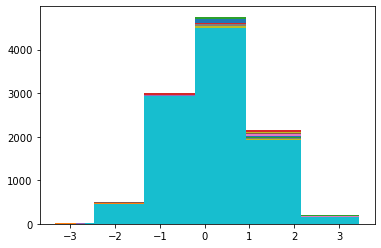

In [37]:
boot_hist_content = np.zeros( shape=(n_samples, fitting_hist_n_bins ))


simple_calc_mean = np.zeros( n_samples )
simple_calc_cov  = np.zeros( n_samples )

of_weight_sum = np.zeros( n_samples )


for bi in range(n_samples) :

    
    rd = read_sample( sample_input_dir, bi )

    ngen_true = rd['ngen_true']
    ngen_train = rd['ngen_train']

    true_pts = rd['true_pts']
    true_det_pts = rd['true_det_pts']
    train_pts = rd['train_pts']
    train_det_pts = rd['train_det_pts']
    
    
            
    fname = '%s/bootstrap-weights-%03d.npy' % (input_dir, bi)

    if not exists(fname) :  
        print('\n\n *** Missing %s' % fname )
        continue

    with open(fname,'rb') as f :            

        final_push_weights_scaled = np.load(f)
        print(' boot %3d weights: ' % bi, end='')
        print( final_push_weights_scaled)

        of_weight_sum[bi] = np.sum( final_push_weights_scaled )

        hist_content,_,_ = plt.hist( train_pts[:,0], bins=fitting_hist_bins, weights=final_push_weights_scaled )
        #print(hist_content)
        boot_hist_content[bi,:] = hist_content


        mean_cov = calc_mean_cov( final_push_weights_scaled, 0, 0 )

        simple_calc_mean[bi] = mean_cov['mean_x1']
        simple_calc_cov[bi]  = mean_cov['cov_x1x2']
        
        
        

<function matplotlib.pyplot.show(close=None, block=None)>

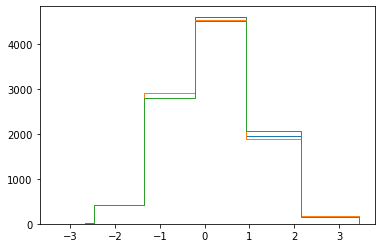

In [38]:
plt.stairs( boot_hist_content[0,:], edges=fitting_hist_bins )
plt.stairs( boot_hist_content[1,:], edges=fitting_hist_bins )
plt.stairs( boot_hist_content[2,:], edges=fitting_hist_bins )
plt.show

In [39]:
hist_nbins = fitting_hist_n_bins


hist_corr_mat = np.zeros( shape=(hist_nbins, hist_nbins) )
hist_cov_mat = np.zeros( shape=(hist_nbins, hist_nbins) )

for bi in range(hist_nbins) :
    
    for bj in range( hist_nbins ) :
        
        ccm = np.corrcoef( np.row_stack( ((boot_hist_content[:,bi], boot_hist_content[:,bj])) ) )
        cvm =      np.cov( np.row_stack( ((boot_hist_content[:,bi], boot_hist_content[:,bj])) ) )
        
        hist_corr_mat[bi,bj] = ccm[0,1]
        
        hist_cov_mat[bi,bj] = cvm[0,1]
        
        if bi == bj : hist_cov_mat[bi,bj] = hist_cov_mat[bi,bj] + diagonal_constant
        

In [40]:
hist_corr_mat[0,hist_nbins-1] = -1.

In [41]:
min_cov_element = np.min(hist_cov_mat)
max_cov_element = np.max(hist_cov_mat)
print('\n\n Min and max elements of cov mat:  %.2f , %.2f\n\n' % (min_cov_element, max_cov_element))
hist_cov_mat_copy = np.copy( hist_cov_mat )
hist_cov_mat_copy[0,hist_nbins-1] = -1. * max_cov_element



 Min and max elements of cov mat:  -1431.87 , 3251.56




<function matplotlib.pyplot.show(close=None, block=None)>

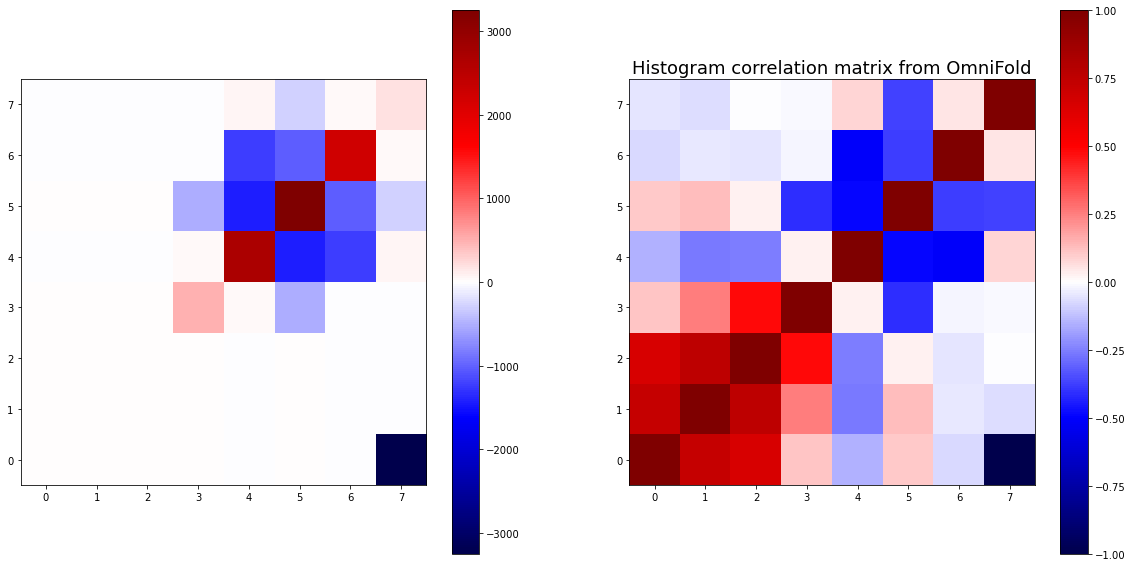

In [42]:
fig,ax = plt.subplots( 1, 2, figsize=(2*10,10))


im_covmat = ax[0].imshow(hist_cov_mat_copy, cmap='seismic', origin='lower')
ax[0].figure.colorbar( im_covmat, ax=ax[0] )

im = ax[1].imshow(hist_corr_mat, cmap='seismic', origin='lower')
ax[1].figure.colorbar( im, ax=ax[1] )



ax[1].set_title('Histogram correlation matrix from OmniFold', fontsize=18)



plt.show

In [43]:
hist_cov_inv = np.linalg.inv( hist_cov_mat )
cov_inv_test = np.matmul( hist_cov_mat, hist_cov_inv )

In [44]:
hist_cov_mat_diagonal = np.copy( hist_cov_mat )
for bi in range(hist_nbins) :
    for bj in range(hist_nbins) :
        if bi != bj : hist_cov_mat_diagonal[bi,bj] = 0.

In [45]:
hist_cov_inv_diagonal = np.linalg.inv( hist_cov_mat_diagonal )

In [46]:
ci_min = np.min(hist_cov_inv)
ci_max = np.max(hist_cov_inv)
print('\n\n min and max of covariance matrix inverse:  %.2f  %.2f\n\n' % (ci_min, ci_max))

hist_cov_inv_copy = np.copy( hist_cov_inv )
hist_cov_inv_copy[0,hist_nbins-1] = -1. * ci_max



 min and max of covariance matrix inverse:  -0.10  0.68




<function matplotlib.pyplot.show(close=None, block=None)>

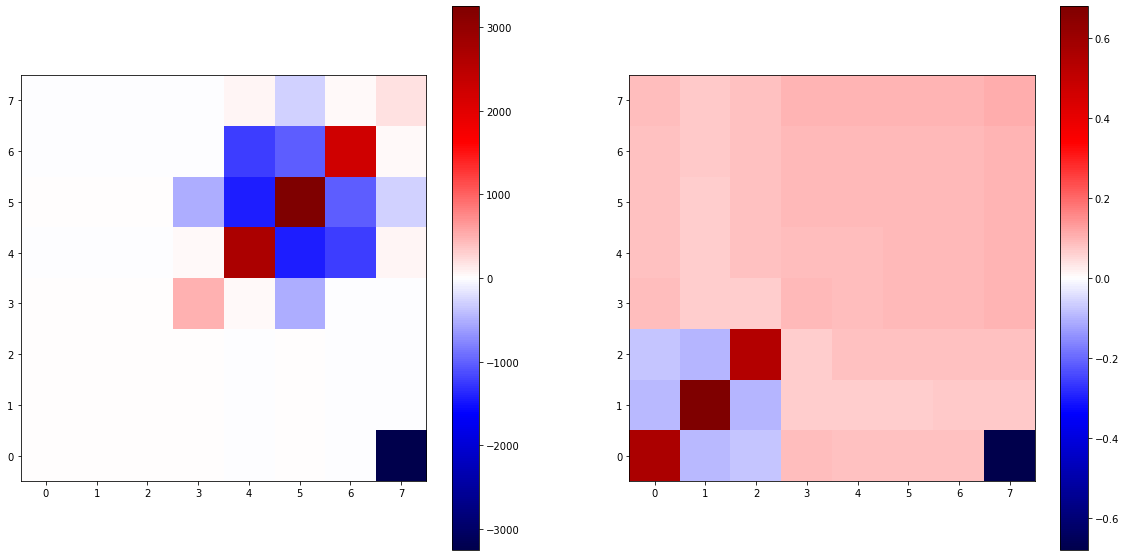

In [47]:
fig,ax = plt.subplots( 1, 2, figsize=(2*10,10))


im_covmat = ax[0].imshow(hist_cov_mat_copy, cmap='seismic', origin='lower')
ax[0].figure.colorbar( im_covmat, ax=ax[0] )

im = ax[1].imshow(hist_cov_inv_copy, cmap='seismic', origin='lower')
ax[1].figure.colorbar( im, ax=ax[1] )







plt.show

In [48]:

hist_cov_pinv = np.linalg.pinv( hist_cov_mat, rcond_val )


In [49]:
hist_cov_pinv_minus_inv = hist_cov_pinv - hist_cov_inv
cov_pinv_test = np.matmul( hist_cov_mat, hist_cov_pinv )

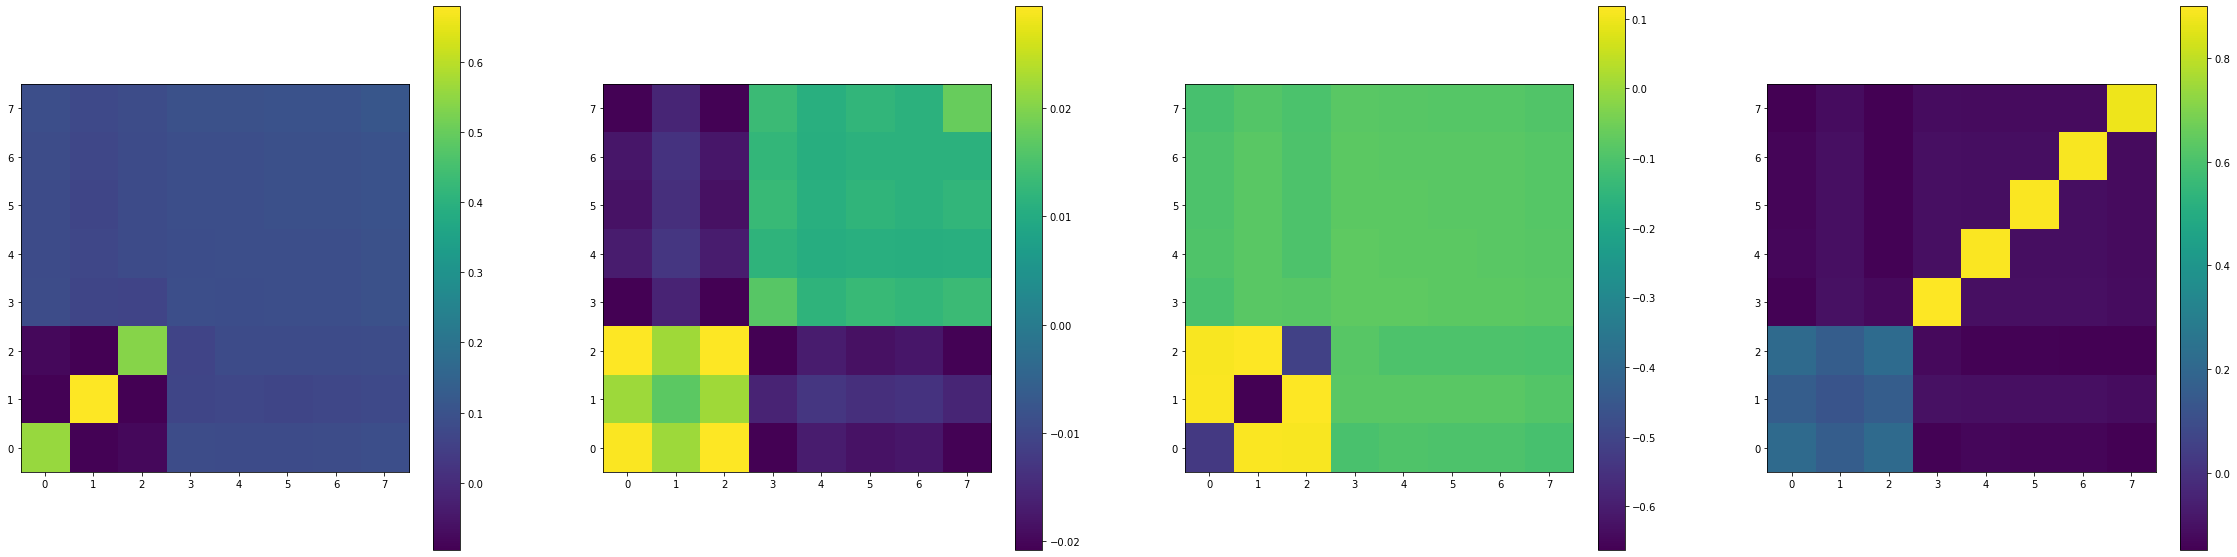

In [50]:
fig,ax = plt.subplots( 1, 4, figsize=(4*10,10))



im_covinv = ax[0].imshow(hist_cov_inv, origin='lower')
ax[0].figure.colorbar( im_covinv, ax=ax[0] )

im_covpinv = ax[1].imshow(hist_cov_pinv, origin='lower')
ax[1].figure.colorbar( im_covpinv, ax=ax[1] )

im_covpinvdiff = ax[2].imshow(hist_cov_pinv_minus_inv, origin='lower')
ax[2].figure.colorbar( im_covpinvdiff, ax=ax[2] )

im_pinv_test = ax[3].imshow(cov_pinv_test, origin='lower')
ax[3].figure.colorbar( im_pinv_test, ax=ax[3] )



In [51]:
cpi_min = np.min(hist_cov_pinv)
cpi_max = np.max(hist_cov_pinv)
print('\n\n min and max of covariance matrix pseudo inverse:  %.2f  %.2f\n\n' % (cpi_min, cpi_max))

hist_cov_pinv_copy = np.copy( hist_cov_pinv )
hist_cov_pinv_copy[0,hist_nbins-1] = -1. * cpi_max




 min and max of covariance matrix pseudo inverse:  -0.02  0.03




<function matplotlib.pyplot.show(close=None, block=None)>

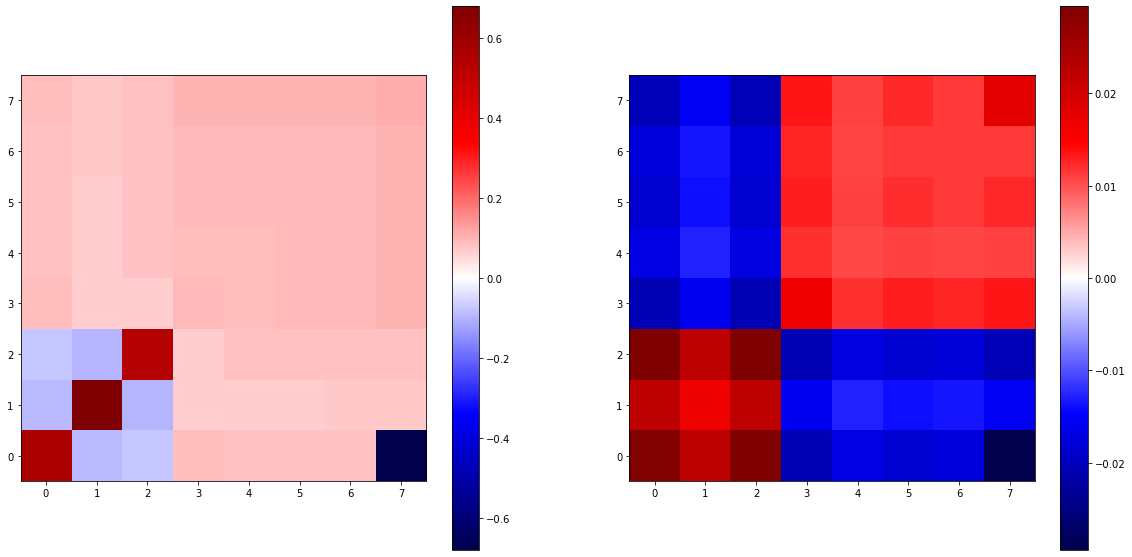

In [52]:
fig,ax = plt.subplots( 1, 2, figsize=(2*10,10))


im_covmat = ax[0].imshow(hist_cov_inv_copy, cmap='seismic', origin='lower')
ax[0].figure.colorbar( im_covmat, ax=ax[0] )

im = ax[1].imshow(hist_cov_pinv_copy, cmap='seismic', origin='lower')
ax[1].figure.colorbar( im, ax=ax[1] )







plt.show

## Set up a Minuit fit

Used this example from Glen Cowan as a starting point: https://github.com/KMISchool2022/histFit/blob/main/histFit.ipynb


In [53]:
import iminuit
from iminuit import Minuit
import scipy.stats as stats
from scipy.stats import chi2

from scipy import special


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [54]:


def f_bin_center_approx(x, par):                      # fit function
    theta   = par[0]
    mu      = par[1]
    sigma2   = par[2]
    
    model_norm =  1. / ( np.sqrt( 2 * 3.14159265 * sigma2 ) )
    
    model_pred = model_norm * np.exp( -0.5 * np.square((x - mu))/sigma2 )
    
    return theta * model_pred



def f_integral_within_bin(x_low, x_high, par):                      # fit function
    theta   = par[0]
    mu      = par[1]
    sigma2   = par[2]
    sigma = np.sqrt(sigma2)
    
    model_pred = 0.5 * ( 1. + special.erf( (x_high - mu )/(sigma*np.sqrt(2.)) ) ) - 0.5 * ( 1. + special.erf( (x_low - mu )/(sigma*np.sqrt(2.)) ) )
    
    return theta * model_pred



class ChiSquared:                   # function to be minimized

    def __init__(self, xHist, bin_edges, covMatInv, fitType, verbose=0):
        self.setData(xHist, bin_edges, covMatInv, verbose)
        self.fitType = fitType
        
    def setData(self, xHist, bin_edges, covMatInv, verbose):
        numVal = np.sum(xHist)
        numBins = len(xHist)
        binLowEdge = np.zeros(numBins)
        binHighEdge = np.zeros(numBins)
        for bi in range(numBins) :
            binLowEdge[bi] = bin_edges[bi]
            binHighEdge[bi] = bin_edges[bi+1]
        binWidth = binHighEdge - binLowEdge
        binCenter = 0.5 * (binLowEdge + binHighEdge)
            
        self.data = xHist, bin_edges, numVal, numBins, binLowEdge, binHighEdge, binWidth, binCenter, covMatInv

        if verbose > 0 :
            print('\n\n setData:')
            print('  numVal: %12.1f  numBins = %d' % (numVal, numBins))
            print('  binLowEdge: ', end='' )
            print('  fitType: %s' % fitType )
            print( binLowEdge)


        
    def chi2LS_integral_within_bin(self, par):
        
        xHist, bin_edges, numVal, numBins, binLowEdge, binHighEdge, binWidth, binCenter, covMatInv = self.data
        
        binProb = f_integral_within_bin(binLowEdge, binHighEdge, par)
        
        nu = numVal*binProb
        
        dy = xHist - nu
        
        cov_inv_times_dy = np.tensordot( covMatInv, dy.T, axes=(1,0) )
        
        dy_times_cov_inv_times_dy =  np.sum( dy.T * cov_inv_times_dy, axis=0)
        
        return dy_times_cov_inv_times_dy
        


    def chi2LS_bin_center_approx(self, par):
        
        xHist, bin_edges, numVal, numBins, binLowEdge, binHighEdge, binWidth, binCenter, covMatInv = self.data
        
        binProb = f_bin_center_approx(binCenter, par) * binWidth
        
        nu = numVal*binProb
        
        dy = xHist - nu
        
        cov_inv_times_dy = np.tensordot( covMatInv, dy.T, axes=(1,0) )
        
        dy_times_cov_inv_times_dy =  np.sum( dy.T * cov_inv_times_dy, axis=0)
        
        return dy_times_cov_inv_times_dy
        


        
    def __call__(self, par):
        if fitType == 'integral within bin' :
            return self.chi2LS_integral_within_bin(par)
        elif fitType == 'bin center approximation' :
            return self.chi2LS_bin_center_approx(par)
        else :
            print('\n\n *** Unknown fitType :  %s\n\n' % fitType )
            return -1

        
        

In [55]:

chi2_fit_mu_val = np.zeros( len(boot_hist_content) )
chi2_fit_mu_err = np.zeros( len(boot_hist_content) )

chi2_fit_sig2_val = np.zeros( len(boot_hist_content) )
chi2_fit_sig2_err = np.zeros( len(boot_hist_content) )

chi2_fit_diag_mu_val = np.zeros( len(boot_hist_content) )
chi2_fit_diag_mu_err = np.zeros( len(boot_hist_content) )

chi2_fit_diag_sig2_val = np.zeros( len(boot_hist_content) )
chi2_fit_diag_sig2_err = np.zeros( len(boot_hist_content) )



for si in range( len(boot_hist_content) ) :
    
    # Initialize Minuit and set up fit:
    theta = 1
    mu = 0.2
    sigma2 = 0.81
    #fitType = 'full cov'

    parin   = np.array([theta, mu, sigma2])      # initial values (here = true)
    parname = ['theta', 'mu', 'sigma2']
    parname_latex = [r'$\theta$', r'$\mu$', r'$\sigma^2$']
    parstep = np.array([0.01, 0.1, 0.1])           # initial setp sizes
    parfix  = [False, False, False]            # change to fix/free param.
    parlim  = [(0.5, 1.5), (None, None), (0., None)]

    chisq = ChiSquared( boot_hist_content[si], fitting_hist_bins, hist_cov_pinv, fitType)
    chisq_diag = ChiSquared( boot_hist_content[si], fitting_hist_bins, hist_cov_inv_diagonal, fitType)


    m = Minuit(chisq, parin, name=parname)
    m.errors = parstep
    m.fixed = parfix
    m.limits = parlim
    m.errordef = 1.0                      # errors from chi2 = chi2min + 1


    m_diag = Minuit(chisq_diag, parin, name=parname)
    m_diag.errors = parstep
    m_diag.fixed = parfix
    m_diag.limits = parlim
    m_diag.errordef = 1.0                      # errors from chi2 = chi2min + 1    
    
    
    # do the fit, get errors, extract results
    m.migrad()                                        # minimize -logL
    parhat = m.values                                 # max-likelihood estimates
    sigma_parhat = m.errors                           # standard deviations
    cov = m.covariance                                # covariance matrix
    rho = m.covariance.correlation()                  # correlation coeffs.

    m_diag.migrad()                                        # minimize -logL
    parhat_diag = m_diag.values                                 # max-likelihood estimates
    sigma_parhat_diag = m_diag.errors                           # standard deviations
    cov_diag = m_diag.covariance                                # covariance matrix
    rho_diag = m_diag.covariance.correlation()                  # correlation coeffs.

    
    chi2_fit_mu_val[si] = parhat[1]
    chi2_fit_mu_err[si] = sigma_parhat[1]

    chi2_fit_sig2_val[si] = parhat[2]
    chi2_fit_sig2_err[si] = sigma_parhat[2]

    
    chi2_fit_diag_mu_val[si] = parhat_diag[1]
    chi2_fit_diag_mu_err[si] = sigma_parhat_diag[1]

    chi2_fit_diag_sig2_val[si] = parhat_diag[2]
    chi2_fit_diag_sig2_err[si] = sigma_parhat_diag[2]

    
    

    
    
    
    print(' %3d : mu %8.4f +/- %8.4f  (%8.4f +/- %8.4f)    sig2 %8.4f +/- %8.4f  (%8.4f +/- %8.4f)' %
          (si, 
           parhat[1], sigma_parhat[1],
           parhat_diag[1], sigma_parhat_diag[1],
           parhat[2], sigma_parhat[2],
           parhat_diag[2], sigma_parhat_diag[2],
          )
         )
    

   0 : mu   0.2080 +/-   0.0118  (  0.2053 +/-   0.0100)    sig2   0.8262 +/-   0.0186  (  0.8268 +/-   0.0137)
   1 : mu   0.1933 +/-   0.0118  (  0.1895 +/-   0.0101)    sig2   0.8366 +/-   0.0186  (  0.8295 +/-   0.0135)
   2 : mu   0.2157 +/-   0.0118  (  0.2150 +/-   0.0100)    sig2   0.8274 +/-   0.0178  (  0.8398 +/-   0.0135)
   3 : mu   0.2046 +/-   0.0118  (  0.2039 +/-   0.0101)    sig2   0.8532 +/-   0.0181  (  0.8537 +/-   0.0133)
   4 : mu   0.2042 +/-   0.0118  (  0.2055 +/-   0.0100)    sig2   0.8416 +/-   0.0185  (  0.8304 +/-   0.0134)
   5 : mu   0.1910 +/-   0.0118  (  0.1929 +/-   0.0100)    sig2   0.8296 +/-   0.0183  (  0.8277 +/-   0.0134)
   6 : mu   0.1844 +/-   0.0118  (  0.1848 +/-   0.0101)    sig2   0.8398 +/-   0.0181  (  0.8354 +/-   0.0132)
   7 : mu   0.2092 +/-   0.0118  (  0.2074 +/-   0.0100)    sig2   0.8005 +/-   0.0182  (  0.7988 +/-   0.0136)
   8 : mu   0.2034 +/-   0.0118  (  0.2057 +/-   0.0100)    sig2   0.8341 +/-   0.0181  (  0.8340 +/-   

  92 : mu   0.1831 +/-   0.0118  (  0.1794 +/-   0.0100)    sig2   0.8320 +/-   0.0184  (  0.8426 +/-   0.0136)
  93 : mu   0.2039 +/-   0.0118  (  0.2107 +/-   0.0101)    sig2   0.8705 +/-   0.0176  (  0.8718 +/-   0.0130)
  94 : mu   0.1955 +/-   0.0118  (  0.1962 +/-   0.0100)    sig2   0.7852 +/-   0.0177  (  0.7871 +/-   0.0134)
  95 : mu   0.1959 +/-   0.0119  (  0.1915 +/-   0.0100)    sig2   0.8301 +/-   0.0181  (  0.8539 +/-   0.0137)
  96 : mu   0.1958 +/-   0.0118  (  0.1947 +/-   0.0100)    sig2   0.8281 +/-   0.0182  (  0.8347 +/-   0.0136)
  97 : mu   0.1845 +/-   0.0118  (  0.1847 +/-   0.0101)    sig2   0.8384 +/-   0.0179  (  0.8463 +/-   0.0133)
  98 : mu   0.1951 +/-   0.0118  (  0.1957 +/-   0.0101)    sig2   0.8175 +/-   0.0176  (  0.8193 +/-   0.0132)
  99 : mu   0.2223 +/-   0.0118  (  0.2223 +/-   0.0101)    sig2   0.8392 +/-   0.0180  (  0.8331 +/-   0.0133)
 100 : mu   0.1865 +/-   0.0118  (  0.1893 +/-   0.0100)    sig2   0.8430 +/-   0.0183  (  0.8369 +/-   

 167 : mu   0.1938 +/-   0.0118  (  0.1937 +/-   0.0100)    sig2   0.8190 +/-   0.0179  (  0.8277 +/-   0.0135)
 168 : mu   0.1997 +/-   0.0118  (  0.2025 +/-   0.0100)    sig2   0.8328 +/-   0.0178  (  0.8363 +/-   0.0133)
 169 : mu   0.1970 +/-   0.0118  (  0.1972 +/-   0.0100)    sig2   0.8269 +/-   0.0181  (  0.8255 +/-   0.0134)
 170 : mu   0.2023 +/-   0.0118  (  0.2008 +/-   0.0100)    sig2   0.8332 +/-   0.0182  (  0.8397 +/-   0.0135)
 171 : mu   0.2161 +/-   0.0118  (  0.2132 +/-   0.0100)    sig2   0.8219 +/-   0.0180  (  0.8275 +/-   0.0135)
 172 : mu   0.2168 +/-   0.0118  (  0.2174 +/-   0.0101)    sig2   0.8460 +/-   0.0182  (  0.8334 +/-   0.0132)
 173 : mu   0.1984 +/-   0.0118  (  0.2013 +/-   0.0100)    sig2   0.8387 +/-   0.0180  (  0.8343 +/-   0.0132)
 174 : mu   0.2037 +/-   0.0118  (  0.2030 +/-   0.0100)    sig2   0.8154 +/-   0.0185  (  0.8103 +/-   0.0136)
 175 : mu   0.2096 +/-   0.0118  (  0.2102 +/-   0.0100)    sig2   0.8302 +/-   0.0182  (  0.8292 +/-   

 248 : mu   0.2081 +/-   0.0118  (  0.2100 +/-   0.0100)    sig2   0.8485 +/-   0.0182  (  0.8472 +/-   0.0134)
 249 : mu   0.2015 +/-   0.0118  (  0.2040 +/-   0.0101)    sig2   0.8631 +/-   0.0184  (  0.8487 +/-   0.0133)
 250 : mu   0.1886 +/-   0.0118  (  0.1862 +/-   0.0100)    sig2   0.8040 +/-   0.0181  (  0.8194 +/-   0.0137)
 251 : mu   0.1934 +/-   0.0118  (  0.1930 +/-   0.0101)    sig2   0.8717 +/-   0.0185  (  0.8677 +/-   0.0133)
 252 : mu   0.1923 +/-   0.0118  (  0.1881 +/-   0.0101)    sig2   0.8043 +/-   0.0180  (  0.8049 +/-   0.0134)
 253 : mu   0.2051 +/-   0.0118  (  0.2031 +/-   0.0100)    sig2   0.8134 +/-   0.0184  (  0.8165 +/-   0.0137)
 254 : mu   0.1880 +/-   0.0118  (  0.1874 +/-   0.0101)    sig2   0.8272 +/-   0.0180  (  0.8282 +/-   0.0133)
 255 : mu   0.2008 +/-   0.0118  (  0.2005 +/-   0.0100)    sig2   0.8147 +/-   0.0179  (  0.8174 +/-   0.0134)
 256 : mu   0.1897 +/-   0.0118  (  0.1885 +/-   0.0100)    sig2   0.8008 +/-   0.0177  (  0.8025 +/-   

 352 : mu   0.1940 +/-   0.0118  (  0.1926 +/-   0.0100)    sig2   0.8371 +/-   0.0184  (  0.8382 +/-   0.0135)
 353 : mu   0.2002 +/-   0.0118  (  0.1970 +/-   0.0100)    sig2   0.8116 +/-   0.0184  (  0.8067 +/-   0.0135)
 354 : mu   0.2132 +/-   0.0118  (  0.2125 +/-   0.0100)    sig2   0.8161 +/-   0.0182  (  0.8172 +/-   0.0136)
 355 : mu   0.1976 +/-   0.0118  (  0.1943 +/-   0.0100)    sig2   0.8102 +/-   0.0181  (  0.8263 +/-   0.0137)
 356 : mu   0.2142 +/-   0.0118  (  0.2095 +/-   0.0100)    sig2   0.8222 +/-   0.0187  (  0.8228 +/-   0.0138)
 357 : mu   0.1834 +/-   0.0118  (  0.1811 +/-   0.0100)    sig2   0.8582 +/-   0.0187  (  0.8612 +/-   0.0136)
 358 : mu   0.2102 +/-   0.0118  (  0.2096 +/-   0.0100)    sig2   0.8283 +/-   0.0183  (  0.8341 +/-   0.0136)
 359 : mu   0.1740 +/-   0.0118  (  0.1739 +/-   0.0101)    sig2   0.8438 +/-   0.0183  (  0.8366 +/-   0.0133)
 360 : mu   0.1961 +/-   0.0118  (  0.1979 +/-   0.0100)    sig2   0.8330 +/-   0.0178  (  0.8396 +/-   

 455 : mu   0.2156 +/-   0.0118  (  0.2165 +/-   0.0101)    sig2   0.8257 +/-   0.0175  (  0.8318 +/-   0.0132)
 456 : mu   0.2048 +/-   0.0118  (  0.2064 +/-   0.0101)    sig2   0.8346 +/-   0.0182  (  0.8203 +/-   0.0132)
 457 : mu   0.2018 +/-   0.0118  (  0.2000 +/-   0.0100)    sig2   0.8103 +/-   0.0179  (  0.8201 +/-   0.0135)
 458 : mu   0.1965 +/-   0.0118  (  0.2000 +/-   0.0100)    sig2   0.8330 +/-   0.0182  (  0.8308 +/-   0.0134)
 459 : mu   0.1849 +/-   0.0118  (  0.1817 +/-   0.0101)    sig2   0.8344 +/-   0.0186  (  0.8237 +/-   0.0134)
 460 : mu   0.2370 +/-   0.0119  (  0.2357 +/-   0.0100)    sig2   0.8239 +/-   0.0183  (  0.8307 +/-   0.0138)
 461 : mu   0.2059 +/-   0.0118  (  0.2049 +/-   0.0100)    sig2   0.8189 +/-   0.0180  (  0.8181 +/-   0.0134)
 462 : mu   0.1936 +/-   0.0118  (  0.1946 +/-   0.0100)    sig2   0.8241 +/-   0.0181  (  0.8200 +/-   0.0134)
 463 : mu   0.1956 +/-   0.0118  (  0.1941 +/-   0.0100)    sig2   0.8135 +/-   0.0185  (  0.8093 +/-   

<function matplotlib.pyplot.show(close=None, block=None)>

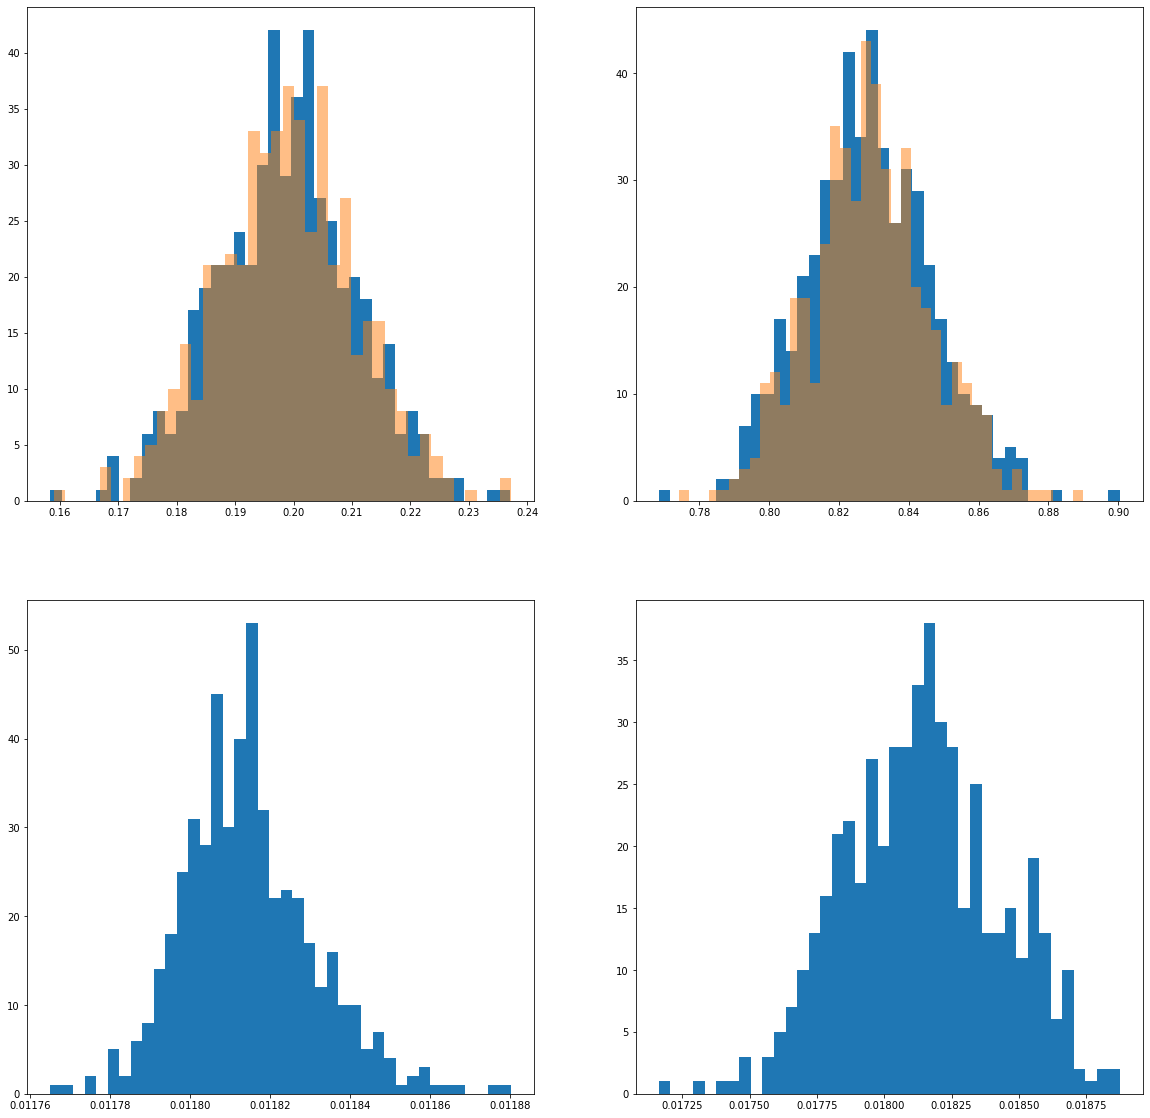

In [56]:
fig,ax = plt.subplots( 2, 2, figsize=(2*10,2*10))

ax[0][0].hist( chi2_fit_mu_val, bins=40 )
ax[0][0].hist( chi2_fit_diag_mu_val, bins=40, alpha=0.5 )

ax[0][1].hist( chi2_fit_sig2_val, bins=40 )
ax[0][1].hist( chi2_fit_diag_sig2_val, bins=40, alpha=0.5 )


ax[1][0].hist( chi2_fit_mu_err, bins=40 )

ax[1][1].hist( chi2_fit_sig2_err, bins=40 )


plt.show

In [57]:


mean_mu = np.mean( chi2_fit_mu_val )
mean_mu2 = np.mean( chi2_fit_mu_val * chi2_fit_mu_val )
rms_mu = np.sqrt( mean_mu2 - mean_mu * mean_mu )

mean_sig2 = np.mean( chi2_fit_sig2_val )
mean_sig22 = np.mean( chi2_fit_sig2_val * chi2_fit_sig2_val )
rms_sig2 = np.sqrt( mean_sig22 - mean_sig2 * mean_sig2 )

mean_mu_fit_err = np.mean( chi2_fit_mu_err )
mean_sig2_fit_err = np.mean( chi2_fit_sig2_err )





mean_mu_diag = np.mean( chi2_fit_diag_mu_val )
mean_mu2_diag = np.mean( chi2_fit_diag_mu_val * chi2_fit_diag_mu_val )
rms_mu_diag = np.sqrt( mean_mu2_diag - mean_mu_diag * mean_mu_diag )

mean_sig2_diag = np.mean( chi2_fit_diag_sig2_val )
mean_sig22_diag = np.mean( chi2_fit_diag_sig2_val * chi2_fit_diag_sig2_val )
rms_sig2_diag = np.sqrt( mean_sig22_diag - mean_sig2_diag * mean_sig2_diag )

mean_mu_fit_err_diag = np.mean( chi2_fit_diag_mu_err )
mean_sig2_fit_err_diag = np.mean( chi2_fit_diag_sig2_err )




print('\n\n')
print(' mean: %7.4f, rms %7.4f, mean fit err %7.4f  |  diag. chi2 fit   %7.4f, rms %7.4f, mean fit err %7.4f' % 
      (mean_mu, rms_mu, mean_mu_fit_err,    mean_mu_diag, rms_mu_diag, mean_mu_fit_err_diag))
print(' sig2: %7.4f, rms %7.4f, mean fit err %7.4f  |  diag. chi2 fit   %7.4f, rms %7.4f, mean fit err %7.4f' % 
      (mean_sig2, rms_sig2, mean_sig2_fit_err,   mean_sig2_diag, rms_sig2_diag, mean_sig2_fit_err_diag))
print('\n\n')





 mean:  0.1988, rms  0.0118, mean fit err  0.0118  |  diag. chi2 fit    0.1987, rms  0.0119, mean fit err  0.0100
 sig2:  0.8288, rms  0.0181, mean fit err  0.0181  |  diag. chi2 fit    0.8292, rms  0.0172, mean fit err  0.0134





In [58]:
with open( '%s/chi2-fit-results.npy' % input_dir, 'wb' ) as f :
    np.save( f, chi2_fit_mu_val )
    np.save( f, chi2_fit_sig2_val )
    np.save( f, chi2_fit_mu_err )
    np.save( f, chi2_fit_sig2_err )
    np.save( f, chi2_fit_diag_mu_val )
    np.save( f, chi2_fit_diag_sig2_val )
    np.save( f, chi2_fit_diag_mu_err )
    np.save( f, chi2_fit_diag_sig2_err )
    
    
    
    